# Intuitons
Here I will show you how I created all of the Facial Expression Recognition on Tensorflow 2 with FER+ dataset.  
First, we need to configure all the dataset into one Numpy arrays

In [1]:
import numpy as np
import matplotlib.pyplot as plt

![image.png](../assets/data_prep_wf.png)

# Raw Data - FER2013
* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* 48 X 48 gray scale images
* 28,709 training samples
* 3,589 validation data
* 3,589 test data
* 7 emotion labels (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
* ~60-65% human accuracy in labelling

![image.png](../assets/test_raw_data.png)

# Data Preparation is Critical
* State of the Art accuracy using a Convolutional Neural Network (CNN) model directly on this raw data is **63%** [1].
* State of the Art accuracy using a slightly modified Convolutional Neural Network (CNN) model after processing the data is **83%** [2].

# Processed Data - FER+

Follow the instructions listed in the README file - https://github.com/TalkAI/facial-emotion-recognition-gluon#before-you-start
* FER+ has new corrected labels
* FER+ has 8 emotions - (0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness', 4: 'anger', 5: 'disgust', 6: 'fear',7: 'contempt')
* Image augmentations:
    * Crop faces in the images – bounding box in the FER+ dataset
    * Scale image size from 48 X 48 -> 64 X 64
    * Shift image
    * Flip image
    * Rotate (angle) image
    * Normalize the pixels in the image

| Emotion  | Train  | Val  |  Test |
|---|---|---|---|
| neutral  |8733   |  1180 | 1083  |
| happiness  | 7284  | 862  | 892  |
| surprise  | 3136  | 411  | 394  |
| sadness  | 3022  | 348  | 382  |
| anger  | 2098  |  289 |  269 |
| disgust  | 116  | 25  | 16  |
| fear  | 536  | 60  | 86  |
| comtempt  | 120  | 16  | 15  |

In [2]:
# Declaration of variables of 8 Emotions we want to recognize
emotion_labels = {0:'Neutral',1:'Happiness',2:'Surprise',3:'Sadness',4:'Anger',5:'Disgust',6:'Fear',7:'Contempt'}
num_classes = 8

In [3]:
train_images = np.load('../data/fer_train_processed_images.npy')
train_labels = np.load('../data/fer_train_processed_labels.npy')
train_images = train_images.reshape(train_images.shape[0], train_images.shape[2], train_images.shape[3], 1).astype('float32') / 255
print(train_images.shape, train_labels.shape)

(25045, 64, 64, 1) (25045, 8)


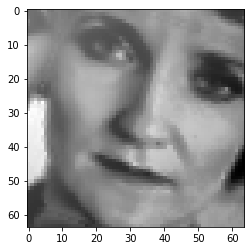

In [4]:
from matplotlib import pyplot as plt
plt.imshow(train_images[987].reshape(64,64), cmap='gray')

In [5]:
test_images = np.load('../data/fer_test_processed_images.npy')
test_labels = np.load('../data/fer_test_processed_labels.npy')
val_images = np.load('../data/fer_val_processed_images.npy')
val_labels = np.load('../data/fer_val_processed_labels.npy')

In [6]:
test_images = test_images.reshape(test_images.shape[0], test_images.shape[2], test_images.shape[3], 1).astype('float32') / 255
print(test_images.shape, test_labels.shape)
val_images = val_images.reshape(val_images.shape[0], val_images.shape[2], val_images.shape[3], 1).astype('float32') / 255
print(val_images.shape, val_labels.shape)

(3137, 64, 64, 1) (3137, 8)
(3191, 64, 64, 1) (3191, 8)


![image.png](../assets/model_training_prep_wf.png)

# Step 1 – Construct the Neural Network

### 13 layer VGGNet presented in the paper [2]
![image.png](../assets/network.png)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D

img_rows, img_cols = 64, 64

In [8]:
model = Sequential()

# Construct 13 layer VGGNet suggested in the paper
# Feature Learning Layer 0
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', activation='elu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', activation='elu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

# Feature Learning Layer 1
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

# Feature Learning Layer 2
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

# Feature Learning Layer 3
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

# Feature Learning Layer 4
model.add(Flatten())
model.add(Dense(1024, kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Feature Learning Layer 5
model.add(Dense(1024, kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Feature Learning Layer 6
model.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

Summary representation of the model:

In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

 # Step 2 – Initialize the callback parameters in Neural Network



Model callbacks: A set of functions to be applied during training

   1. Checkpointer: Save the model after every epoch.
   2. Reduce LR: Reduce learning rate when a metric has stopped improving
   3. Early Stop: Stop training when a monitored quantity has stopped improving.

We define our fbeta metric[6] instead of going for accuracy in account of Accuracy paradox.[3] The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.


In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

checkpoint = ModelCheckpoint('Model_emotion_recognition.h5', monitor='val_loss', mode='min', 
                             save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=0.0001, 
                              min_lr=0, cooldown=0)
tensor_board = TensorBoard(log_dir='./graph')
callbacks = [early_stop, checkpoint, reduce_lr, tensor_board]

from tensorflow.keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))



Model compiling configures the model for training. Adam optimizer can be considered an extension to SGD. And as defined above, our metric will be based on fbeta and accuracy score.


In [11]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', fbeta])


We can now train our model we created earlier on the data generated by the previous step of augmentated data. Here, we mention steps parameter which is nothing but how many steps will be taken to complete a epoch with a given batch size.

# Step 3 – Prepare data loaders

Below, are the hyper-parameters defined for the CNN:

   * Batch size: determines the number of input samples to be fed to the network together.  
   * Shuffle buffer size : determines the number of shuffle buffer to be fed on training data.
   * Epoch: an epoch is when all of the data is seen by the network once.

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100
epochs = 25

Here we are using <b>from_tensor_slices</b> class for loading the dataset

In [13]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE).shuffle(SHUFFLE_BUFFER_SIZE).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE).repeat()


# Step 4 – Train the Neural Network

On a total of n samples taking k samples (batch size) and , each epoch will have n/k steps

In [14]:
nb_train_samples = 25045
nb_validation_samples = 3191

In [ ]:
%%time
history = model.fit(train_dataset, epochs=epochs, callbacks=callbacks, validation_data=val_dataset,
                    steps_per_epoch=nb_train_samples // BATCH_SIZE,
                    validation_steps=nb_validation_samples // BATCH_SIZE, verbose=1)

Epoch 1/25
782/782 [==============================] - ETA: 0s - loss: 1.9029 - accuracy: 0.3995 - fbeta: 0.2815 

# Step 5 - Evaluate on Test Data



Once the model is trained, we run it on test data and see how it performs. The below code gives us the loss and the accuracy of the network when run on test data


In [ ]:
score = model.evaluate(test_dataset, steps=len(test_images[0]) // BATCH_SIZE)
print('Evaluation loss: ', score[0])
print('Evaluation accuracy: ', score[1])



For the training and validaton sets, lets plot the graphs of accuracy and loss over the epochs


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], color='b', label='Training')
plt.plot(history.history['val_accuracy'], color='y', label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
# plt.savefig("Accuracy.png") # For saving figure purposes

# summarize history for loss
plt.plot(history.history['loss'], color='b', label='Training')
plt.plot(history.history['val_loss'], color='y', label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()
#plt.savefig('Loss.png') # For saving figure purposes



The correctness of the model can be easily visualized with a confustion matrix(also known as error matrix) oftenly used for classification problems.[5] Correct predictions are located in a diagonal line from top-left to bottom-right. The confusion matrix shows the ways in which your classification model is confused when it makes predictions.

True positives for a few emotions will be less of course owing to the fact that the training on it was done with a limited data compared to the other emotions which underwent ample of training.

In [ ]:
y_pred = model.predict_classes(test_images)
y_true = np.asarray([np.argmax(i) for i in test_labels])

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, cmap="Blues", 
                 yticklabels=emotion_labels, xticklabels=emotion_labels, vmin=0, 
                 vmax=np.max(cm_normalised), fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

![image.png](../assets/inference_wf.png)

# Step 6 - Export the model for Production

In [ ]:
#model.save("/SavedModel", overwrite=True)
model_json = model.to_json()
with open("emotion_classification.json", "w") as json_file:
    json_file.write(model_json)

# References
1. I. J. Goodfellow, D. Erhan, P. L. Carrier, A. Courville,
M. Mirza, B. Hamner, W. Cukierski, Y. Tang,
D. Thaler, D.-H. Lee, et al. Challenges in
representation learning: A report on three machine
learning contests. In Neural information processing,
pages 117–124. Springer, 2013

2. Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution Emad Barsoum et. al. https://arxiv.org/abs/1608.01041
